### Learning in LTN

In [ ]:
#%pip install matplotlib

In [8]:
import ltn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

lets take

The domain is the square  [0,4] x [0,4]
. We have one example of the class 
 and one example of the class 
. The rest of the individuals are not labelled, but there are two assumptions:

- A and b  are mutually exclusive,
- any two close points should share the same label.

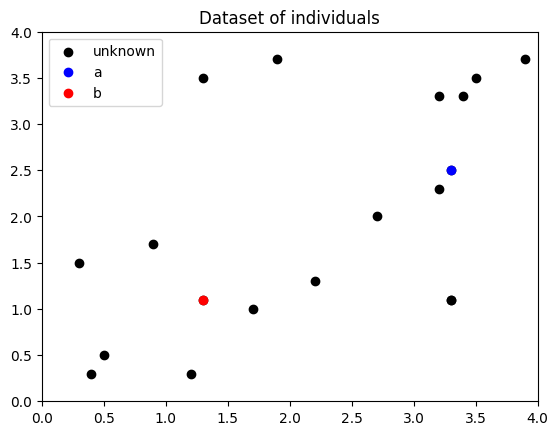

In [9]:
points = np.array(
        [[0.4,0.3],[1.2,0.3],[2.2,1.3],[1.7,1.0],[0.5,0.5],[0.3, 1.5],[1.3, 1.1],[0.9, 1.7],
        [3.4,3.3],[3.2,3.3],[3.2,2.3],[2.7,2.0],[3.5,3.5],[3.3, 2.5],[3.3, 1.1],[1.9, 3.7],[1.3, 3.5],[3.3, 1.1],[3.9, 3.7]])
point_a = [3.3,2.5]
point_b = [1.3,1.1]
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black",label="unknown")
ax.scatter(point_a[0],point_a[1],color="blue",label="a")
ax.scatter(point_b[0],point_b[1],color="red",label="b")
ax.set_title("Dataset of individuals")
plt.legend();



1) We have two classes (say A and B).
2) We know the labels of two points only (a belongs to A, b belongs to B).
3) We also know that similar points should have the same label.
4) We want a neural network to learn the classifier only using logic rules.

- No dataset.
- No cross-entropy.
- Only logic satisfaction.


### MemberShip Predicate C(x,l)

- x = datapoint
- l = label(class A or B)
- C(x,l) -> "x belongs to class l"

here l = one-hot
- Class A -> [1,0]
- Class B -> [0,1]

- C(x, [1,0]) = probability x is class A
- C(x, [0,1]) = probability x is class B

### C is approxiated by simple MLP
- means the logic predicate C is a Neural Network
- Cθ : (x_vector, l_onehot) → [0,1]
    -   Input: vector representation of x
    -   Output: probabilities for each class
means,
- C(x) = softmax(MLP(x))

“The last layer uses a softmax activation ensuring classes are mutually exclusive.”

### The Knowldge Base K
- The KB is a set of logical rules the network must satisfy.

Rules: 
1. C(a,l_a) = individual a belongs to lable l_a
    -  The network must output high probability for a being class A
2. C(b,l_b) = b is know to be in Class B
3. All(x1,x2,l)(Sim(x1,x2)-> (C(x1,l)<-> C(x2,l)))
    -   If two points are similar, then they should belong to the same class

### Grounding
- Grounding = turning logic into numbers
- | Symbol      | Grounding               |
- | ----------- | ----------------------- |
- | Individual  | vector                  |
- | Predicate   | neural network          |
- | Similarity  | distance-based function |
- | Logical AND | multiplication          |
- | ∀           | mean / min              |

- Without grounding:
    -Logic is symbolic
- With grounding:
    -Logic is differentiable


### Learning Objective
$$ \theta^{*} = argmax SatAgg_{\phi \in K}G_{\theta}(\phi) $$

- Find neural network parameters that make all logic rules as true as possible

### What is happening during trainning
1. Initialize embeddings + MLP randomly
2. Compute:
- C(a, lₐ)
- C(b, lᵦ)
-Similarity constraints
4. Aggregate satisfaction
5. Compute gradients
6. Update network
7. Repeat

Over time:
- Similar points cluster
- Labels propagate
- Rules become more satisfied

### Picture:
- Points → vectors
- Vectors → classifier
- Classifier → probabilities
- Probabilities → logic truth
- Logic truth → loss


In [10]:
class ModelC(tf.keras.Model):
    def __init__(self):
        super(ModelC, self).__init__()
        self.dense1 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense3 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)

    def call(self, inputs):
        """inputs[0]: point, inputs[1]: onehot label"""
        x, label = inputs[0], inputs[1]
        x = self.dense1(x)
        x = self.dense2(x)
        prob = self.dense3(x)
        return tf.math.reduce_sum(prob*label,axis=1)

C = ltn.Predicate(ModelC())

In [11]:
x1 = ltn.Variable("x1",points)
x2 = ltn.Variable("x2",points)
a = ltn.Constant([3.3,2.5], trainable=False)
b = ltn.Constant([1.3,1.1], trainable=False)
l_a = ltn.Constant([1,0], trainable=False)
l_b = ltn.Constant([0,1], trainable=False)
l = ltn.Variable("l",[[1,0],[0,1]])

Sim = ltn.Predicate.Lambda(
    lambda args: tf.exp(-1.*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

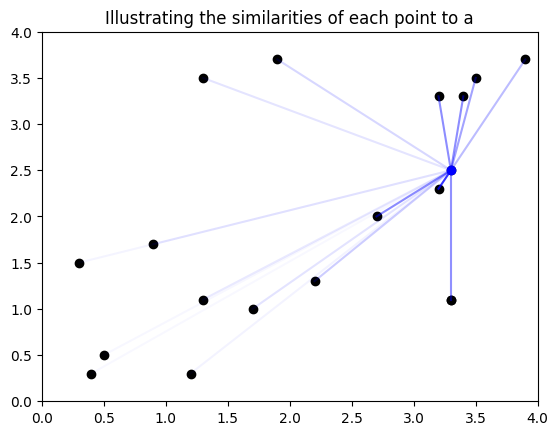

In [12]:
similarities_to_a = Sim([x1,a]).tensor
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black")
ax.scatter(a.tensor[0],a.tensor[1],color="blue")
ax.set_title("Illustrating the similarities of each point to a")
for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0],a.tensor[0]],[points[i,1],a.tensor[1]], alpha=sim_to_a.numpy(),color="blue")

In [13]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

In [14]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms():
    axioms = [
        C([a,l_a]),
        C([b,l_b]),
        Forall(
            [x1,x2,l],
            Implies( Sim([x1,x2]),
                    Equiv(C([x1,l]),C([x2,l]))
                   )
        )
    ]
    kb = formula_aggregator(axioms)
    sat = kb.tensor
    return sat

In [16]:
# Force a forward pass to build the underlying Keras model variables
_ = C([x1, l_a])

trainable_variables = C.trainable_variables
assert len(trainable_variables) > 0, "No trainable variables found in predicate C. Make sure the model was built."

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch % 200 == 0:
        print("Epoch %d: Sat Level %.3f" % (epoch, axioms()))
print("Training finished at Epoch %d with Sat Level %.3f" % (epoch, axioms()))

Epoch 0: Sat Level 0.594
Epoch 200: Sat Level 0.874
Epoch 400: Sat Level 0.948
Epoch 600: Sat Level 0.953
Epoch 800: Sat Level 0.954
Epoch 1000: Sat Level 0.954
Epoch 1200: Sat Level 0.954
Epoch 1400: Sat Level 0.955
Epoch 1600: Sat Level 0.955
Epoch 1800: Sat Level 0.955
Training finished at Epoch 1999 with Sat Level 0.955


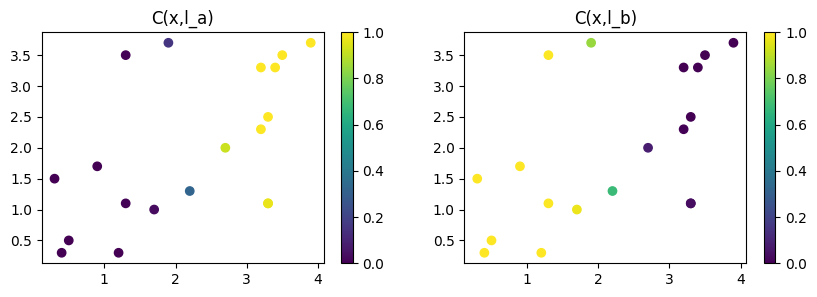

In [17]:
fig = plt.figure(figsize=(10,3))
fig.add_subplot(1,2,1)
is_a = C([x1,l_a])
plt.scatter(x1.tensor[:,0],x1.tensor[:,1],c=is_a.tensor.numpy(),vmin=0,vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1,2,2)
is_b = C([x1,l_b])
plt.scatter(x1.tensor[:,0],x1.tensor[:,1],c=is_b.tensor.numpy(),vmin=0,vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();